In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re
import scipy.io
import os

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform

In [4]:
os.chdir("../dhsindex")

In [5]:
dhs = pd.read_csv("DHS_Index_and_Vocabulary_hg38_WM20190703.txt.gz", sep = "\t", low_memory=False)
dhs.component.value_counts()

In [7]:
matrix = scipy.io.mmread("dat_bin_FDR01_hg38.mtx.gz")
transposed = matrix.transpose()
matrix.shape

In [180]:
sample_meta = pd.read_csv("DHS_Index_and_Vocabulary_metadata.tsv", sep = "\t")
sample_meta = sample_meta.iloc[:-1,:]
sample_meta["Organ"] = sample_meta["Organ"].fillna("Bone")
sample_meta

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,729.0,fUmbilical_cord,NaN,ENCSR512CWR,ENCLB771UER,ENCBS518LEK,ENCFF267RUD,AG7441,LN45036A,DS24820A,...,NaN,NaN,0.9,1260000.0,A+Sucrose,2017-02-17,195057523.0,0.5652,113517.0,112469.0
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0


/tmp/ipykernel_32058/3934776008.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Pastel1', len(unique_labels))(range(len(unique_labels)))


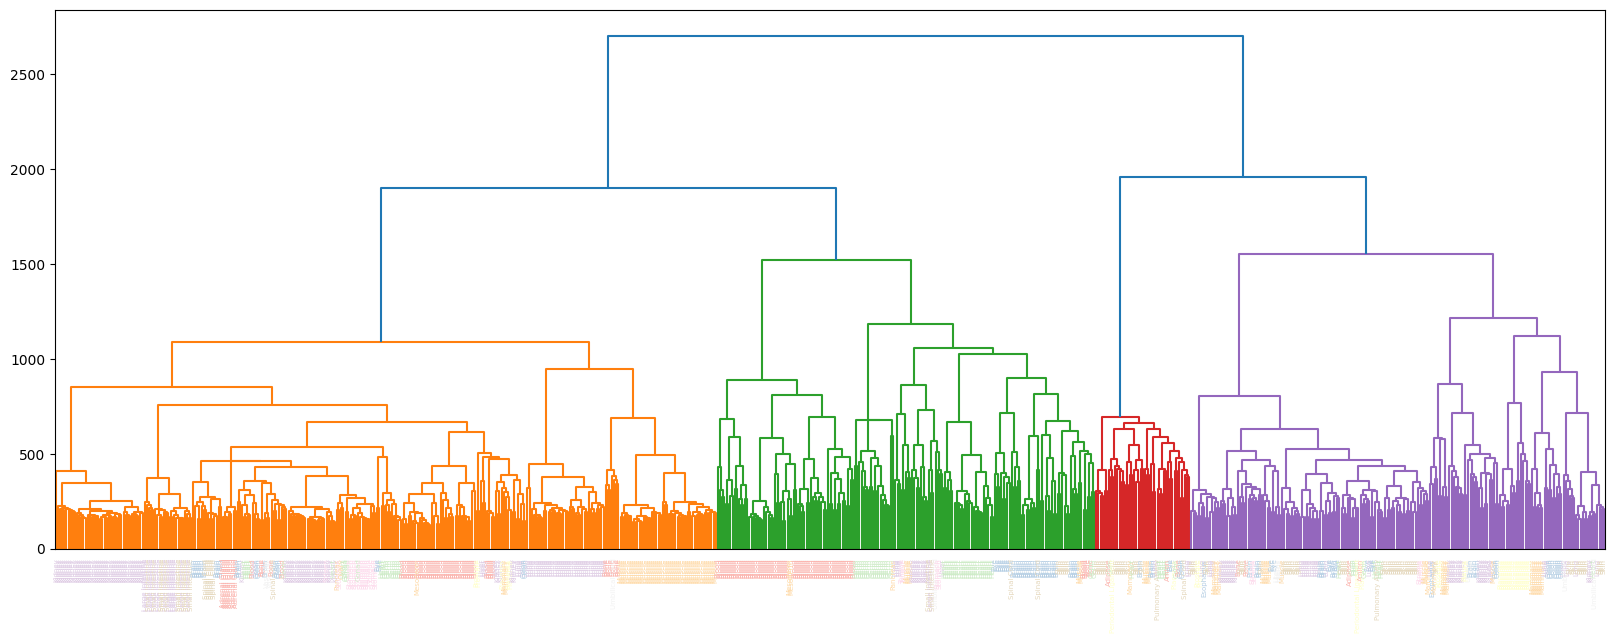

In [88]:
pairwise_dist = pairwise_distances(transposed, metric='euclidean')
pairwise_dist = squareform(pairwise_dist)
linkage_matrix = linkage(pairwise_dist, method='ward', metric='precomputed')

labels = sample_meta["Organ"].astype(str).to_numpy()
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('Pastel1', len(unique_labels))(range(len(unique_labels)))
color_map = dict(zip(unique_labels, colors))

plt.figure(figsize=(20, 7))
dendro = dendrogram(linkage_matrix, labels=labels)

# Color the labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_map[lbl.get_text()])
plt.savefig("dend.pdf")
plt.show()

In [90]:
desired_clusters = 100

sorted_distances = sorted(linkage_matrix[:, 2], reverse=True)
distance_threshold = sorted_distances[desired_clusters - 1]

distance_threshold

457.3370019289203

## Cluster within (organ,biosample type) pairs

In [183]:
organ_type = sample_meta[["Organ","Biosample type"]].drop_duplicates()
organ_type

,Organ,Biosample type
0,Blood,Lines
1,Liver,Cancer
2,Blood,Primary
3,Uterus,Cancer
4,Colon,Cancer
...,...,...
664,Liver,Lines
709,Kidney,Lines
716,Pancreas,Lines
717,Bone,Primary


In [184]:
labels = np.empty(sample_meta.shape[0], dtype='object')

transposed_csr = transposed.tocsr()

for i in range(organ_type.shape[0]): 
    #print(i)
    organ = organ_type["Organ"].iloc[i]
    biosample_type = organ_type["Biosample type"].iloc[i]
    to_keep = (sample_meta["Organ"] == organ) & (sample_meta["Biosample type"] == biosample_type)

    if to_keep.sum() <= 1: 
        labels[to_keep] = [ f"{organ}_{biosample_type}_{0}" ]
        continue
    
    X = transposed_csr[to_keep,:]
    pairwise_dist = pairwise_distances(X)
    condensed_dist_matrix = squareform(pairwise_dist)
    
    linkage_matrix = linkage(condensed_dist_matrix, method='ward')
    
    clusters = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

    labels[to_keep] = [ f"{organ}_{biosample_type}_{clu}" for clu in clusters ]

#dendrogram(linkage_matrix, labels = clusters, leaf_rotation=45)
#dendrogram(linkage_matrix, labels = sample_meta["Description "][to_keep].to_numpy(), leaf_rotation=45)
#plt.show()
#labels[to_keep]

In [186]:
pd.Series(labels).value_counts().head(10)

Kidney_Primary_2             41
Lung_Primary_7               37
Muscle_Primary_3             27
Kidney_Primary_3             25
Blood_Primary_6              22
Muscle_Primary_2             20
Blood_Primary_7              15
Large Intestine_Primary_1    13
Skin_Primary_6               12
Skin_Primary_7               12
Name: count, dtype: int64

In [187]:
sample_meta["my_cluster"] = labels

In [207]:
unique_labels = np.unique(labels.astype(str))

In [208]:
import string

translator = str.maketrans('', '', string.punctuation)
des = sample_meta["Description "].astype(str).str.translate(translator)

to_remove = {"human", "cells", "the", "from", "Human", "cell", "Cells", "to", "with", "an", '-', "w/"}

description_terms = []

for label in unique_labels: 
    list_of_lists = [g.split() for g in des[labels == label] ] 
    vc = pd.Series(sum(list_of_lists, [])).value_counts()
    common_set = set(vc[vc>=2].index) - to_remove
    if len(common_set) == 0: 
        common_set = set(vc[vc>=1].index) - to_remove
    description_terms.append(label + ":" + ",".join(common_set))


In [209]:
for label in unique_labels:
    m = np.asarray(transposed_csr[labels == label,:].mean(0)).flatten()
    open_chrom = m > 0.5
    dhs[open_chrom].iloc[:,:3].to_csv(f"bed/{label}_ATAC.bed.gz", sep="\t", index=False, header=False)

In [212]:
sample_meta

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index,my_cluster
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0,Blood_Lines_1
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0,Liver_Cancer_1
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0,Blood_Primary_3
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0,Uterus_Cancer_1
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0,Colon_Cancer_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,729.0,fUmbilical_cord,NaN,ENCSR512CWR,ENCLB771UER,ENCBS518LEK,ENCFF267RUD,AG7441,LN45036A,DS24820A,...,NaN,0.9,1260000.0,A+Sucrose,2017-02-17,195057523.0,0.5652,113517.0,112469.0,Umbilical Cord_Primary_1
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0,Bone_Primary_1
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0,Liver_Primary_0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0,Placenta_Primary_5


In [227]:
meta = pd.DataFrame({
    "filename" : [ f"{label}_ATAC.bed.gz" for label in unique_labels ], 
    "original" : [ ",".join(sample_meta["DCC File ID"][labels == label]) for label in unique_labels ], 
    "tissue" : description_terms
})

meta["assay"] = "ATAC"
meta["species"] = "homo_sapiens"

meta = meta[["tissue","assay","species","filename","original"]]

meta.to_csv("meta.tsv", sep="\t", index=False)

['Adipose_Primary_1:derived,Adipocytes,AFMSC',
 'Adrenal Gland_Primary_1:Adrenal',
 'Amion_Primary_1:Amniotic,Epithelial',
 'Blood_Cancer_1:Myeloid,nan',
 'Blood_Cancer_2:NonHodgkin,Bcell,Burkitts,lymphoma,Lymphoma',
 'Blood_Cancer_3:blood,myeloma,peripheral,plasmacytoma',
 'Blood_Cancer_4:B,lymphoma,nonhodgkin',
 'Blood_Cancer_5:line,haploid,KBM7,derived,nearhaploid,Parental',
 'Blood_Cancer_6:Leukemia,leukemia,Acute,T',
 'Blood_Cancer_7:P00174E07,Haplogen,Clone',
 'Blood_Lines_1:Lymphoblastoid',
 'Blood_Primary_1:CD,34,control,0,CD34,Hematopoietic,progenitor',
 'Blood_Primary_2:T8,Day,CD34,day,6,T6,4,differentiation,8',
 'Blood_Primary_3:induced,T2,helper,T1',
 'Blood_Primary_4:CD8,B,CD4,T',
 'Blood_Primary_5:CD34,day,differentiation,17',
 'Blood_Primary_6:B,CD3,CD4,Thymus,T,CD8,blood,CD19,helper',
 'Blood_Primary_7:CD,34,progenitor,Hematopoietic',
 'Blood_Primary_8:CD14,monocytes',
 'Bone_Cancer_1:Fibrosarcoma,adherent,Osteosarcoma',
 'Bone_Cancer_2:Ewings,Sarcoma',
 'Bone_Cancer_3:

In [225]:
sample_meta["Description "].str.contains("microglia", case=False, regex=False).sum()

0

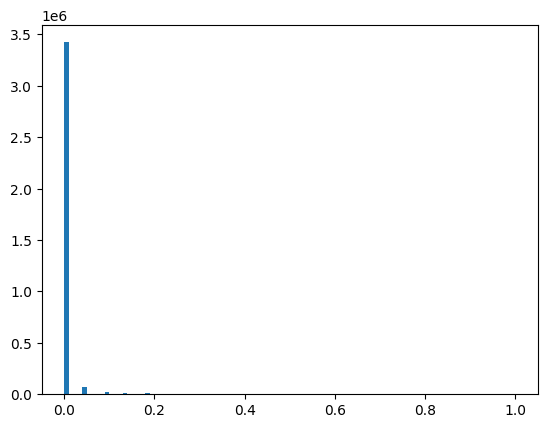

In [138]:
plt.hist(m, 100)
plt.show()

In [144]:
i = 9
sample_meta.loc[clusters == i,"Vocabulary representative"]
sample_meta.loc[clusters == i,"Biosample name"]
sample_meta.loc[clusters == i,"System"] # Hematopoietic
#sample_meta.loc[clusters == i,"Subsystem"] # Progenitor, T-cell, NaN
sample_meta.loc[clusters == i,["System","Organ","Biosample type","Description "]] # Blood, Mesoderm
#sample_meta.loc[clusters == i,"Biosample type"] # Primary
#sample_meta.loc[clusters == i,"Description "] # Detailed


,System,Organ,Biosample type,Description
6,Nervous,Brain,Cancer,Neuroblastoma _Treated with retinoic acid (RA)
77,Endocrine,Adrenal Gland,Primary,Adrenal
100,Cardiovascular,Heart,Primary,Heart
166,Musculoskeletal,Bone,Cancer,Ewing's sarcoma
167,Musculoskeletal,Bone,Cancer,Ewing's sarcoma
225,Nervous,Brain,Primary,Brain
237,Cardiovascular,Heart,Primary,Heart
240,Cardiovascular,Heart,Primary,Heart
425,Cardiovascular,Heart,Primary,Heart
452,Nervous,Brain,Primary,Brain
